# PCA-Based CNN

This notebook explores the use of PCA combined with CNN. The PCA is applied as the first layer of the CNN and before the convolutional layers.

This model has three stages:
- PCA Dimensionality Reduction
- Convolutional Layer
- Fully connected layer

In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import time
import torch.nn.functional as F

from pathlib import Path
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchinfo import summary
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
NUM_CLASSES = 5
IMAGE_SIZE = (200, 200)
BATCH_SIZE = 32
IMAGE_DATASET_PATH = str(Path().absolute()) + "/dataset"
MANUAL_SEED= 42
NUM_EPOCHS = 100
LEARNING_RATE=0.005
VALID_SIZE=0.1
# Set random seed for reproducibility
np.random.seed(MANUAL_SEED)
torch.manual_seed(MANUAL_SEED)

In [3]:
def checkpoint(model, optimizer, filename):
    torch.save({
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
    }, filename)
    
def resume(model, optimizer, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])

## Read the dataset
The dataset will contain the labeled data after reading it from the directory. Include the labels but this won't bear weight on feature reduction.

In [4]:
train_transforms = transforms.Compose([
#     transforms.Grayscale(),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_transforms = transforms.Compose([
#     transforms.Grayscale(),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

In [5]:
train_dataset = torchvision.datasets.ImageFolder(root='dataset/train', transform=train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root='dataset/test', transform=test_transforms)
valid_dataset = torchvision.datasets.ImageFolder(root='dataset/train', transform=train_transforms)

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE,                                     
    shuffle=False)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(VALID_SIZE * num_train))
np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE,
    sampler=train_sampler
)
    
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, 
    batch_size=BATCH_SIZE,
    sampler=valid_sampler
)

## PCAConv2D layer

In [72]:
class PCAConv2D(nn.Module):
    def __init__ (self, n_components, kernel_size=3, stride=1, padding=0):
        super(PCAConv2D, self).__init__()
        self.n_components = n_components
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.has_displayed = False
        
    def forward(self, x):
        batch_size, channels, height, width = x.size()
        
        x_reshaped = x.view(batch_size * height * width, channels)
        
        pca = PCA(n_components=self.n_components, random_state=MANUAL_SEED)
        pca.fit(x_reshaped.detach().cpu().numpy())
        pca_output = pca.transform(x_reshaped.detach().cpu().numpy())
        
        pca_output = torch.from_numpy(pca_output).float().to(x.device).view(batch_size, height, width, self.n_components)
        
        pca_output = pca_output.permute(0, 3, 1, 2)
        
        if(self.has_displayed == False):
            pca_image = pca_output[0].detach().cpu().numpy()
            print(pca_image.shape)
            pca_image = np.moveaxis(pca_image, 0, -1)
            plt.imshow(pca_image)
            plt.axis('off')
            plt.show()
            self.has_displayed = True
        
        return pca_output

## CNN with PCA Layer

In [73]:
class Net(nn.Module):
    def __init__(self, num_classes, n_components):
        super(Net, self).__init__()
        self.conv_computed_size = n_components * num_classes * 100 * 100;
        self.pca_conv = PCAConv2D(n_components=n_components, kernel_size=3, stride=1, padding=1)
        self.conv1 = nn.Conv2d(n_components, n_components * num_classes, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(self.conv_computed_size, 100)
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        x = self.pca_conv(x)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.contiguous().view(-1, self.conv_computed_size)  # Reshape to [batch_size, 32 * 100 * 100]
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [74]:
model = Net(NUM_CLASSES, 3).to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 200, 200)


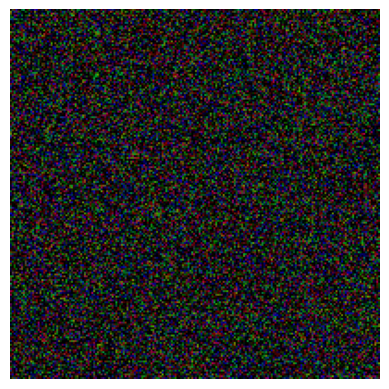

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [32, 5]                   --
├─PCAConv2D: 1-1                         [32, 3, 200, 200]         --
├─Conv2d: 1-2                            [32, 15, 200, 200]        420
├─MaxPool2d: 1-3                         [32, 15, 100, 100]        --
├─Linear: 1-4                            [32, 100]                 15,000,100
├─Linear: 1-5                            [32, 5]                   505
Total params: 15,001,025
Trainable params: 15,001,025
Non-trainable params: 0
Total mult-adds (G): 1.02
Input size (MB): 15.36
Forward/backward pass size (MB): 153.63
Params size (MB): 60.00
Estimated Total Size (MB): 228.99

In [64]:
summary(model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE[0], IMAGE_SIZE[1]))

In [75]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay = 0.005, momentum = 0.9)  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Starting the training process at 0 step, epoch 0...
(3, 200, 200)


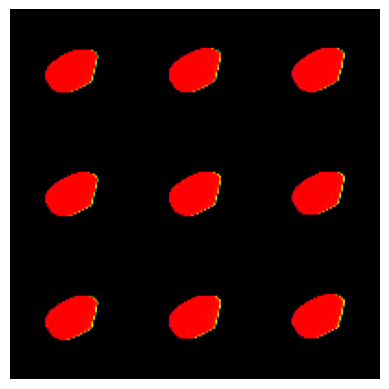

Epoch [1/100], Step [600/1899], Loss: 0.0258, Seconds per 600 images: 103.49423690000003
Epoch [1/100], Step [1200/1899], Loss: 0.0283, Seconds per 600 images: 193.57576699999981
Epoch [1/100], Step [1800/1899], Loss: 0.1417, Seconds per 600 images: 292.68991689999984
Epoch [1/100]: Accuracy of the network: 95.6954732510288 %, Epoch Training Time: 309.79014210000014
Epoch [1/100]: Accuracy of Arborio for training: 93.67140626284211 %. Train Loss 0.003529895760739843
Epoch [1/100]: Accuracy of Basmati for training: 96.14245764105938 %. Train Loss 0.003529895760739843
Epoch [1/100]: Accuracy of Ipsala for training: 99.25925925925925 %. Train Loss 0.003529895760739843
Epoch [1/100]: Accuracy of Jasmine for training: 94.0182911757436 %. Train Loss 0.003529895760739843
Epoch [1/100]: Accuracy of Karacadag for training: 95.38638985005767 %. Train Loss 0.003529895760739843
------------------------------------------------------------
VALIDATING THE MODEL FOR EPOCH 1
Accuracy of the network on 

Accuracy of the network on the 5000 validation images: 98.91851851851851 %
Epoch [7/100], Train Loss: 0.001092653993256735, Val Loss: 5.250089847379261e-05. TIME: 298.11155170000075 seconds
------------------------------------------------------------
Starting the training process at 0 step, epoch 7...
Epoch [8/100], Step [600/1899], Loss: 0.0086, Seconds per 600 images: 106.14013539999996
Epoch [8/100], Step [1200/1899], Loss: 0.0157, Seconds per 600 images: 196.79551579999952
Epoch [8/100], Step [1800/1899], Loss: 0.0182, Seconds per 600 images: 287.98722739999994
Epoch [8/100]: Accuracy of the network: 98.83786008230453 %, Epoch Training Time: 303.84069180000006
Epoch [8/100]: Accuracy of Arborio for training: 97.96991863236623 %. Train Loss 0.0010298313960527864
Epoch [8/100]: Accuracy of Basmati for training: 98.91429511432801 %. Train Loss 0.0010298313960527864
Epoch [8/100]: Accuracy of Ipsala for training: 99.85185185185185 %. Train Loss 0.0010298313960527864
Epoch [8/100]: Accu

In [76]:
total_step = len(train_loader)
start = time.perf_counter()
best_accuracy = -1
start_epoch = 0
start_step = 0
early_stop_thresh = 3
val_loss_per_epoch = {}
train_loss_per_epoch = {}
train_accuracy_per_epoch = {}
val_accuracy_per_epoch = {}
total_step = len(train_loader)
classes = list(train_dataset.class_to_idx.keys())

if start_epoch > 0:
    resume_epoch = start_epoch - 1
    step_number = "full" if start_step == 1689 else start_step
    print("LOADING MODEL...")
    resume(model, optimizer, f"PCACNN-epoch-{resume_epoch}-full.pth")

for epoch in range(start_epoch, NUM_EPOCHS):
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(NUM_CLASSES)]
    n_class_samples = [0 for i in range(NUM_CLASSES)]
    model.train()
    start_epoch_timer = time.perf_counter()
    train_loss = 0.0
    
    for i, (images, labels) in enumerate(train_loader):
        if i < start_step:
            continue
        
        if i == start_step:
            print(f"Starting the training process at {i} step, epoch {epoch}...")
        
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for y in range(labels.size(dim=0)):
            label = labels[y]
            pred = predicted[y]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if (i + 1) % 600 == 0:
            end_batch_timer = time.perf_counter()
#             checkpoint(model, optimizer, f"VGG-epoch-{epoch}-{i}.pth")
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Seconds per 600 images: {}'.format(epoch+1, NUM_EPOCHS, i+1, total_step, loss.item(), (end_batch_timer - start_epoch_timer)))
    train_loss /= len(train_loader.dataset)
    
    if start_step <= 0:
        acc = 100.0 * n_correct / n_samples
        end_epoch_timer = time.perf_counter()
        train_accuracy_per_epoch[epoch] = acc
        checkpoint(model, optimizer, f"PCACNN-epoch-{epoch}-full.pth")
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}]: Accuracy of the network: {acc} %, Epoch Training Time: {end_epoch_timer - start_epoch_timer}')

        for i in range(NUM_CLASSES):
            acc = 100.0 * n_class_correct[i] / n_class_samples[i]
            print(f'Epoch [{epoch+1}/{NUM_EPOCHS}]: Accuracy of {classes[i]} for training: {acc} %. Train Loss {train_loss}')
        print("------------------------------------------------------------")
            
# Validation
# No validation at the moment.
    model.eval()
    with torch.no_grad():
        print(f"VALIDATING THE MODEL FOR EPOCH {epoch + 1}")
        correct = 0
        total = 0
        val_loss = 0.0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            del images, labels, outputs
        val_loss /= len(valid_loader.dataset)
        
        acc = correct / total
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * acc)) 
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss}, Val Loss: {val_loss}. TIME: {end_epoch_timer - start_epoch_timer} seconds")
        
        train_loss_per_epoch[epoch] = train_loss
        val_loss_per_epoch[epoch] = val_loss
        val_accuracy_per_epoch[epoch] = acc
        # Early stopping
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            checkpoint(model, optimizer, "PCACNN_best_model.pth")
        elif epoch - best_epoch > early_stop_thresh:
            print("Early stopped training at epoch %d" % epoch)
            break  # terminate the training loop
        print("------------------------------------------------------------")
end = time.perf_counter()
print(f'{end - start} seconds')

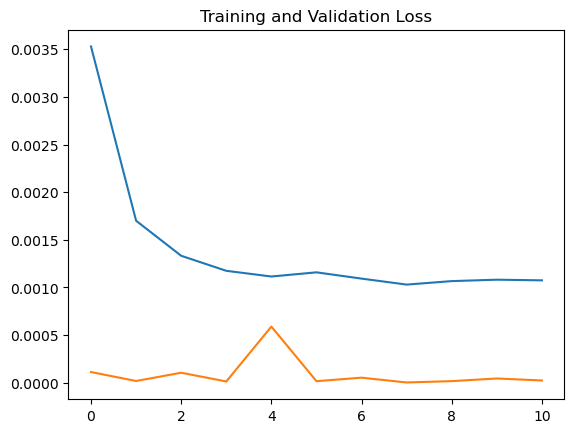

In [81]:
plt.plot(list(train_loss_per_epoch.keys()), list(train_loss_per_epoch.values()), label='Training Loss')
plt.plot(list(val_loss_per_epoch.keys()), list(val_loss_per_epoch.values()), label='Validation Loss')
plt.title('Training and Validation Loss')
plt.show()

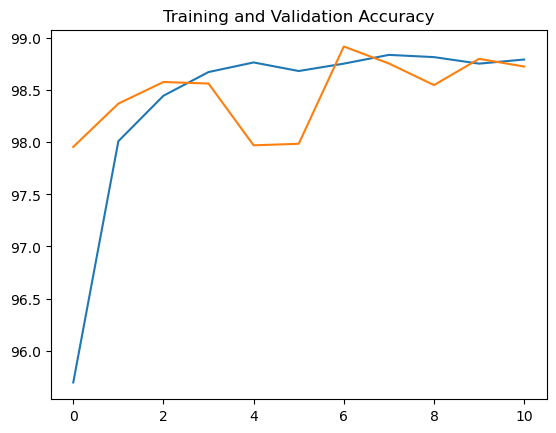

In [93]:
plt.plot(list(train_accuracy_per_epoch.keys()), list(train_accuracy_per_epoch.values()), label='Training Loss')
plt.plot(list(val_accuracy_per_epoch.keys()), [x * 100 for x in list(val_accuracy_per_epoch.values())], label='Validation Loss')
plt.title('Training and Validation Accuracy')
plt.show()

## Best Model

Test the best model on the test data and record the accuracy and loss per batch

In [102]:
resume(model, optimizer, f"PCACNN_best_model.pth")

model.eval()
per_batch_accuracy = {}
per_batch_loss = {}

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(NUM_CLASSES)]
    n_class_samples = [0 for i in range(NUM_CLASSES)]
    val_loss = 0.0
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
#         max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        
        per_batch_accuracy[i] = (predicted == labels).sum().item() / labels.size(0)
        per_batch_loss[i] = loss.item()
        
        for i in range(labels.size(dim=0)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')
    
    for i in range(NUM_CLASSES):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

# with torch.no_grad():
#     model.eval()
#     for i, data in enumerate(test_loader):
#         images = data.to(device)
#         outputs = autoencoder(images)
#         loss = criterion(outputs, images)  # Reconstruction loss
#         val_loss += loss.item()
#     val_loss /= len(ae_validation_loader.dataset)
#     print(f"LOSS FOR TEST DATA: {val_loss:7f}")

Accuracy of the network: 98.97333333333333 %
Accuracy of Arborio: 99.73333333333333 %
Accuracy of Basmati: 97.33333333333333 %
Accuracy of Ipsala: 99.93333333333334 %
Accuracy of Jasmine: 98.73333333333333 %
Accuracy of Karacadag: 99.13333333333334 %


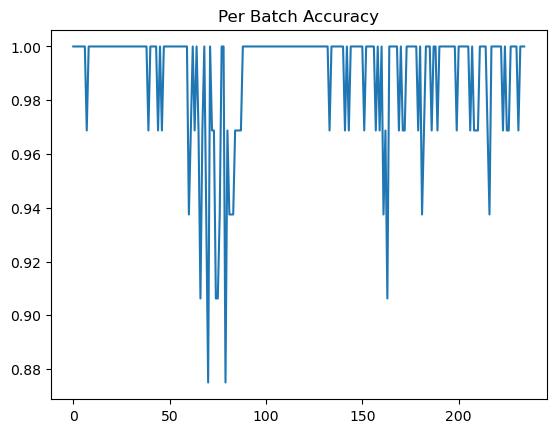

In [106]:
per_batch_accuracy
plt.plot(list(per_batch_accuracy.keys()), list(per_batch_accuracy.values()), label='Training Loss')
plt.title('Per Batch Accuracy')
plt.show()

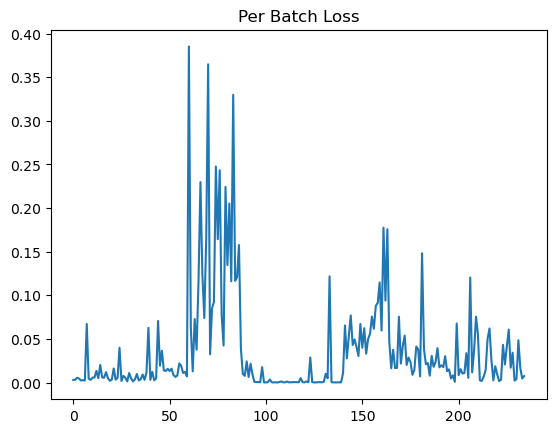

In [105]:
per_batch_accuracy
plt.plot(list(per_batch_loss.keys()), list(per_batch_loss.values()), label='Training Loss')
plt.title('Per Batch Loss')
plt.show()